## Importing libraries

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

## Importing the dataset

In [2]:
INPUT_PATH = "C:/Users/jaint/Downloads/fer2013_cleaned/"

In [3]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Angry has 2832 number of images
disgust has 380 number of images
fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images

total images are 16876


In [4]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

## Data Cleaning and EDA

In [5]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [6]:
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

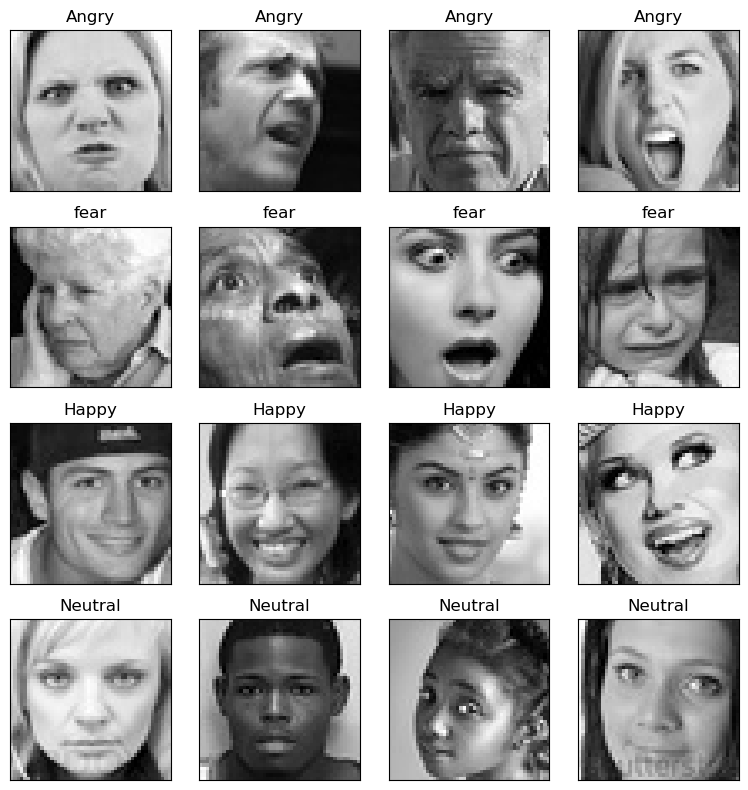

In [7]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [8]:
img_label = to_categorical(img_label)
img_label.shape

(16496, 4)

### Normalizing results as neural networks are sensitive to unnormalized data

In [9]:
img_arr = img_arr / 255.

## Splitting the data into training and validation set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [11]:
del img_arr
del img_label

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

## Obtaining the Mobile Net model

In [13]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 3, 3, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 3, 3, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 3, 3, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 3, 3, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 3, 3, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 3, 3, 512)         262144    
                                                                 
 conv_pw_9

In [15]:
for layer in model.layers[:15]:
    layer.trainable = False

#### As data is less, so we use ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

#### Using two callbacks: 'Early Stopping' for avoiding overfitting of training data and 'ReduceLROnPlateau' for learning rate

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [19]:
batch_size = 32
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/40
463/463 [==============================] - 47s 89ms/step - loss: 0.7318 - accuracy: 0.7150 - val_loss: 0.8206 - val_accuracy: 0.6873 - lr: 0.0100
Epoch 2/40
463/463 [==============================] - 41s 88ms/step - loss: 0.7230 - accuracy: 0.7185 - val_loss: 0.8178 - val_accuracy: 0.6824 - lr: 0.0100
Epoch 3/40
463/463 [==============================] - 41s 89ms/step - loss: 0.7083 - accuracy: 0.7254 - val_loss: 0.7789 - val_accuracy: 0.7170 - lr: 0.0100
Epoch 4/40
463/463 [==============================] - 42s 90ms/step - loss: 0.7074 - accuracy: 0.7230 - val_loss: 1.1308 - val_accuracy: 0.6352 - lr: 0.0100
Epoch 5/40
463/463 [==============================] - 41s 89ms/step - loss: 0.6929 - accuracy: 0.7337 - val_loss: 1.1120 - val_accuracy: 0.5764 - lr: 0.0100
Epoch 6/40
463/463 [==============================] - 41s 88ms/step - loss: 0.6859 - accuracy: 0.7356 - val_loss: 1.0085 - val_accuracy: 0.6673 - lr: 0.0100
Epoch 7/40
464/463 [==============================] - ETA:

In [21]:
model_yaml = model.to_json()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

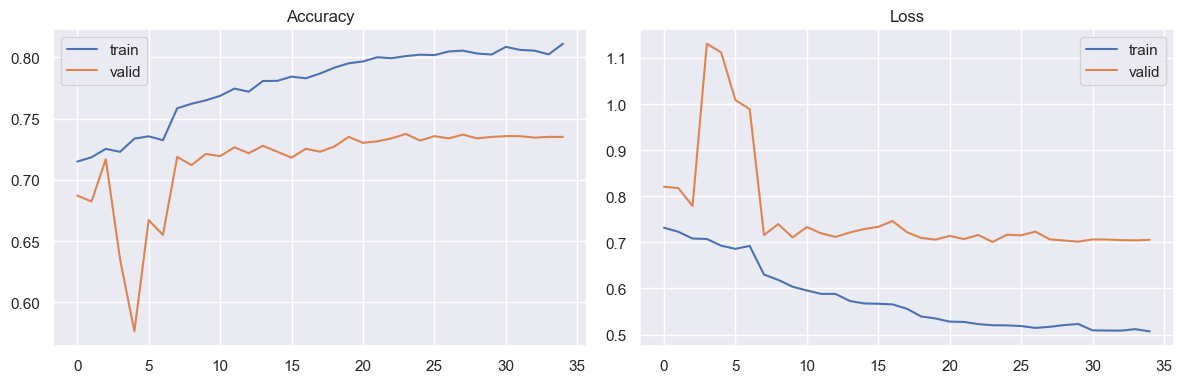

In [25]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [26]:
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

In [27]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 0, 'fear': 1, 'Happy': 2, 'Neutral': 3}

52/52 [==============================] - 2s 25ms/step
test accuracy: 73.7576 %


              precision    recall  f1-score   support

           0       0.61      0.61      0.61       283
           1       0.69      0.48      0.56       253
           2       0.88      0.87      0.88       684
           3       0.64      0.76      0.69       430

    accuracy                           0.74      1650
   macro avg       0.70      0.68      0.69      1650
weighted avg       0.74      0.74      0.73      1650



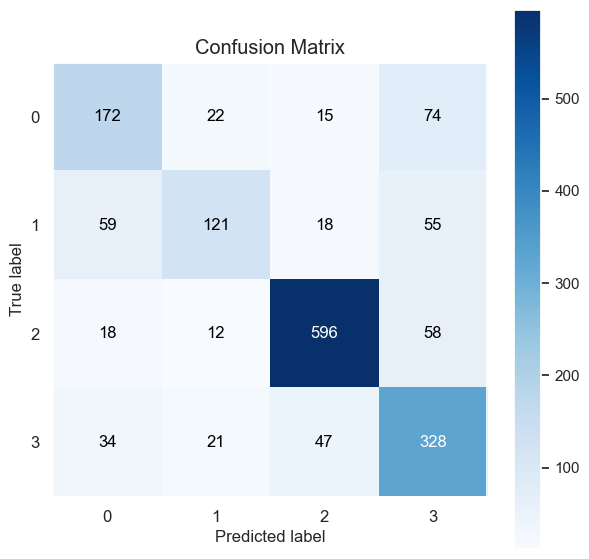

In [28]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

1/1 [==============================] - 0s 38ms/step


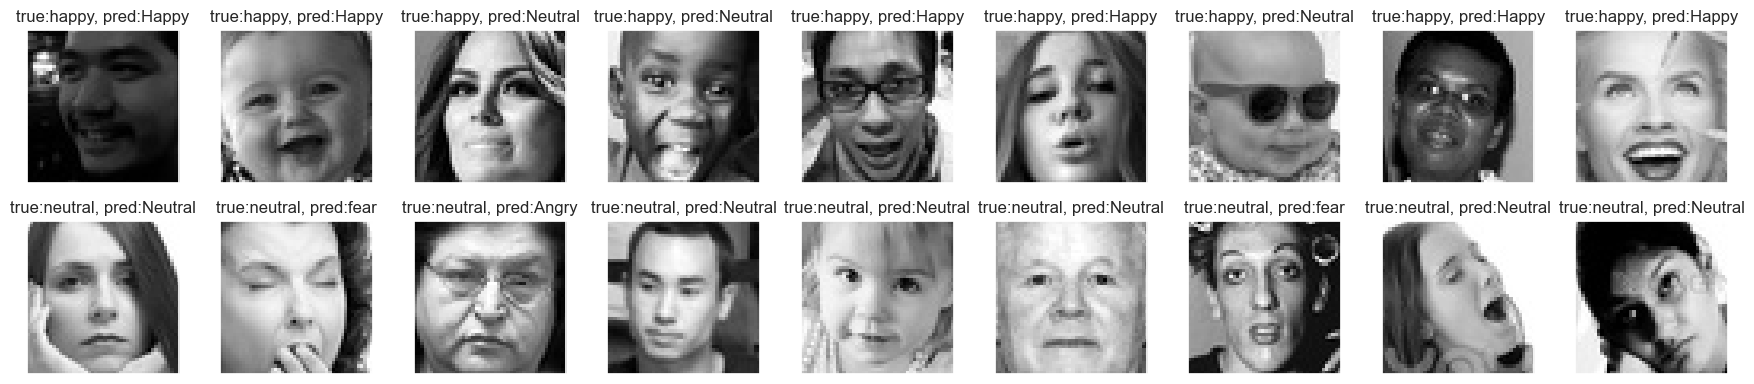

In [33]:
np.random.seed(40)
happy_imgs = np.random.choice(np.where(y_test[:, text_to_label["Happy"]]==1)[0], size=9, replace=False)
neutral_imgs = np.random.choice(np.where(y_test[:, text_to_label["Neutral"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (happy_idx, neutral_idx) in enumerate(zip(happy_imgs, neutral_imgs)):
        sample_img = X_test[happy_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:happy, pred:{pred}")

        sample_img = X_test[neutral_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neutral, pred:{pred}")

        pyplot.tight_layout()